In [1]:
from functools import partial
import h5py as h5
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import joblib as jl
import torch as pt
from pytorch_lightning import Trainer
from precept import PreceptModule, PreceptDataFrameModule
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from hy.contrib.pprint import pp

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
device_type = "nmos"
tech        = "xh035"
data_path   = f"../data/{tech}-{device_type}.h5"

In [4]:
with h5.File(data_path, 'r') as db:
    col_names   = list(db.keys())
    data_matrix = np.transpose(np.array([db[c] for c in col_names]))
    data_raw    = pd.DataFrame(data_matrix, columns=col_names).dropna()

In [6]:
params = ["vth","vdsat","ron","gm","gmbs","gds","betaeff","id","gmoverid"
         ,"vearly","self_gain","rout","pwr","fug"]#,"cgs","cgd","cdb"]
df     = data_raw[params]
cor    = df.corr()

<AxesSubplot:>

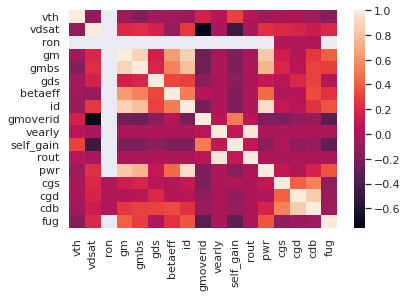

In [7]:
sns.heatmap(cor, xticklabels=cor.columns.values, yticklabels=cor.columns.values)

### Parameters

The parameters of interest as specified during bilateral meeting:

| Parameter   |                                Description                               |
|-------------|:------------------------------------------------------------------------:|
| `beta`      |                           Current amplification                          |
| `betaeff`   |                      Effective current amplification                     |
| `vth`       |                             Treshold voltage                             |
| `vdsat`     |                            Saturation voltage                            |
| `vearly`    |              Equivalent early volrtage: $$ I_{d} / g_{ds} $$             |
| `ron`       | Large signal output resistance: $$ v_{ds} / i_{ds} \approx 1 / g_{ds} $$ |
| `rout`      |                             $$ 1 / g_{ds} $$                             |
| `self_gain` |                        Gain: $$ g_{m} / g_{ds} $$                        |
| `gm`        |                            Transconductance                              |
| `gmb`       |                         Bulk Transconductance                            |
| `gds`       |                         Small signal conductance                         |
| `gmoverid`  |                      Efficiency $$ g_{m} / I_{d} $$                      |
| `id`        |                               Drain current                              |
| `pwr`       |                                   Power                                  |
| `fug`       |                           Unity gain frequency                           |

Some parameters seem to be redundant or can be easily derived. 

In [80]:
parameters = ["vth","vdsat","gmbsoverw","gdsoverw","betaeff","gmoverid","pwr","fug","idoverw","W","L","Vds","Vgs","Vbs"]

In [81]:
data_raw["idoverw"]   = data_raw["id"] / data_raw["W"]
data_raw["gdsoverw"]  = data_raw["gds"] / data_raw["W"]
data_raw["gmbsoverw"] = data_raw["gmbs"] / data_raw["W"]

In [82]:
df = data_raw[parameters]
co = df.corr()

<AxesSubplot:>

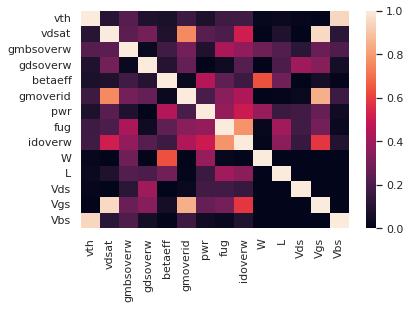

In [83]:
sns.heatmap(co.abs(), xticklabels=co.columns.values, yticklabels=co.columns.values)

Considering the correlation matrix

#### Neural Network:

$$
\begin{bmatrix}
    \log_{10}(|\mathtt{betaeff}|) \\
    \mathtt{gmoverid} \\
    \mathtt{Vds} \\
    \mathtt{Vbs} \\
    \log_{10}(|\mathtt{fug}|) \\
\end{bmatrix}
\mapsto
\begin{bmatrix}
    \mathtt{vth} \\
    \mathtt{Vgs} \\
    \log_{10}(|\mathtt{pwr}|) \\
    \log_{10}(|\mathtt{vdsat}|) \\
    \log_{10}(|\mathtt{gmbsoverw}|) \\
    \log_{10}(|\mathtt{gdsoverw}|) \\
    \log_{10}(|\mathtt{idoverw}|) \\
    \mathtt{L} \\
\end{bmatrix}
$$

#### Wrapper Function:

$$
\begin{bmatrix}
    \mathtt{betaeff} \\
    \mathtt{gmoverid} \\
    \mathtt{id} \\
    \mathtt{pwr} \\
    \mathtt{fug} \\
\end{bmatrix}
\mapsto
\begin{bmatrix}
    \mathtt{vth} \\
    \mathtt{vdsat} \\
    \mathtt{vearly} \\
    \mathtt{gmbsoverw} \\
    \mathtt{gdsoverw} \\
    \mathtt{L} \\
    \mathtt{W} \\
    \mathtt{idoverw} \\
    \mathtt{ron} \\
    \mathtt{rout} \\
    \mathtt{self\_gain} \\
\end{bmatrix}
$$

In [85]:
params_x = ["Vds", "Vbs", "gmoverid","fug","betaeff"]
params_y = ["vth","vdsat","gmbsoverw","gdsoverw","L","idoverw","Vgs","pwr"]

In [86]:
data_x = data_raw[params_x]
data_y = data_raw[params_y]

Text(0.5, 1.0, 'Outputs')

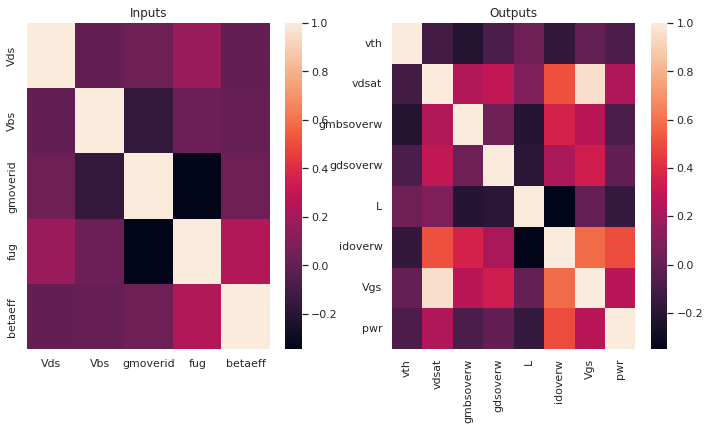

In [87]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
sns.heatmap(data_x.corr(), ax=ax1, xticklabels=params_x, yticklabels=params_x)
sns.heatmap(data_y.corr(), ax=ax2, xticklabels=params_y, yticklabels=params_y)
ax1.set_title("Inputs")
ax2.set_title("Outputs")

In [88]:
data_norm_x = pd.DataFrame(minmax_scale(data_x.values), columns=params_x)
data_norm_y = pd.DataFrame(minmax_scale(data_y.values), columns=params_y)

In [89]:
data_norm_x.describe()

,Vds,Vbs,gmoverid,fug,betaeff
count,1.256920e+06,1.256920e+06,1.256920e+06,1.256920e+06,1.256920e+06
mean,5.000000e-01,5.000000e-01,2.970468e-01,9.546210e-02,6.922278e-02
std,2.930165e-01,3.333335e-01,3.670109e-01,1.848093e-01,1.560419e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.424242e-01,1.666667e-01,2.466848e-02,1.241126e-04,2.010033e-03
50%,5.000000e-01,5.000000e-01,6.292235e-02,8.734993e-03,1.055037e-02
75%,7.575758e-01,8.333333e-01,7.019434e-01,8.800411e-02,5.301463e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Text(0.5, 1.0, 'Scaled Y Parameters')

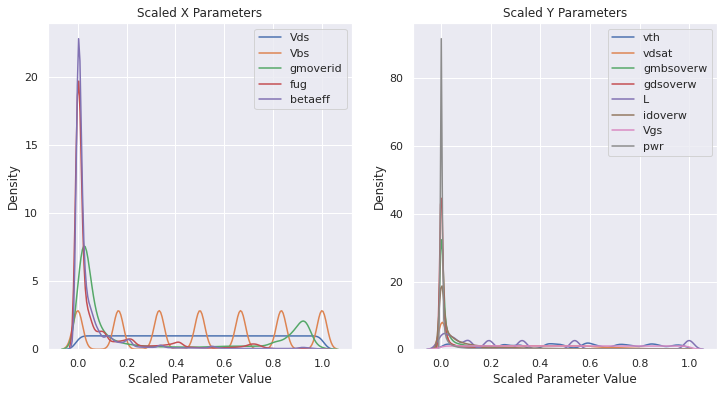

In [90]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,6), nrows=1, ncols=2)

for c in data_norm_x.columns.values:
    sns.kdeplot(data_norm_x[c], ax=ax1, label=c)

for c in data_norm_y.columns.values:
    sns.kdeplot(data_norm_y[c], ax=ax2, label=c)

ax1.set_xlabel("Scaled Parameter Value")
ax1.set_ylabel("Density")
ax1.legend()
ax1.set_title("Scaled X Parameters")
ax2.set_xlabel("Scaled Parameter Value")
ax2.set_ylabel("Density")
ax2.legend()
ax2.set_title("Scaled Y Parameters")

In [91]:
params_t          = ["fug", "betaeff", "pwr", "gmbsoverw", "gdsoverw", "idoverw", "vdsat"]
data_trafo        = data_raw[(params_x + params_y)].copy()

for t in params_t:
    data_trafo[t] = np.log10(np.abs(data_trafo[t].values), where=(data_trafo[t].values != 0))
    
data_scale        = pd.DataFrame(minmax_scale(data_trafo.values), columns=(params_x + params_y))

data_scale_x      = data_scale[params_x]
data_scale_y      = data_scale[params_y]

Text(0.5, 1.0, 'Transformed Y Parameters')

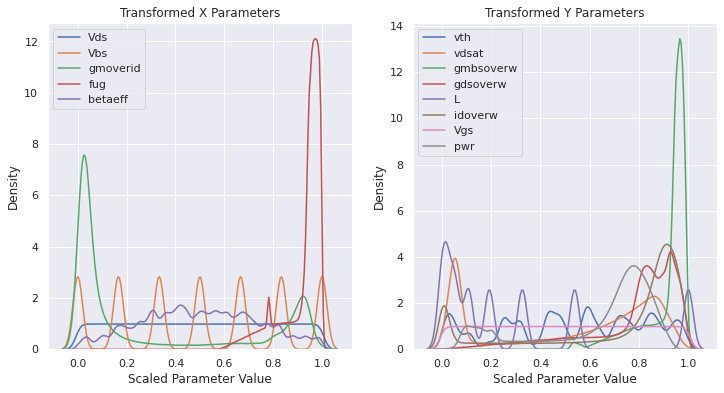

In [92]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,6), nrows=1, ncols=2)

for c in data_scale_x.columns.values:
    sns.kdeplot(data_scale_x[c], ax=ax1, label=c)

for c in data_scale_y.columns.values:
    sns.kdeplot(data_scale_y[c], ax=ax2, label=c)

ax1.set_xlabel("Scaled Parameter Value")
ax1.set_ylabel("Density")
ax1.legend()
ax1.set_title("Transformed X Parameters")
ax2.set_xlabel("Scaled Parameter Value")
ax2.set_ylabel("Density")
ax2.legend()
ax2.set_title("Transformed Y Parameters")

In [93]:
scale_x = MinMaxScaler()
scale_y = MinMaxScaler()

data_scale_x = scale_x.fit_transform(data_trafo[params_x].values)
data_scale_y = scale_y.fit_transform(data_trafo[params_y].values)

In [94]:
data_scale = pd.DataFrame( np.hstack((data_scale_x, data_scale_y))
                         , columns=(params_x + params_y))

In [95]:
model_dir    = f"../models/ifx/po"
model_prefix = f"{model_dir}/{tech}-{device_type}"

data = PreceptDataFrameModule( data_scale, params_x, params_y, [], [], [], []
                             , batch_size = 2000
                             , test_split = 0.2
                             , scale      = False
                             , )

module = PreceptModule( len(params_x), len(params_y)
                      , model_path = model_dir
                      , )

trainer = Trainer( gpus                = 1
                 , max_epochs          = 42
                 , precision           = 32
                 , checkpoint_callback = True
                 , default_root_dir    = model_dir
                 , )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [96]:
trainer.fit(module, data)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 M 
------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.523     Total estimated model params size (MB)


Epoch 0:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 503/629 [00:07<00:01, 66.22it/s, loss=0.0944, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 503/629 [00:07<00:01, 66.71it/s, loss=0.0824, v_num=0, valid_loss=0.161]
Validating: 0it [00:00, ?it/s]
Epoch 2:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 503/629 [00:07<00:01, 68.43it/s, loss=0.0484, v_num=0, valid_loss=0.149]
Validating: 0it [00:00, ?it/s]
Epoch 3:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 503/629 [00:07<00:01, 68.50it/s, loss=0.048, v_num=0, valid_loss=0.0915]
Validating: 0it [00:00, ?it/s]
Epoch 4:  80%|██████████████████████

In [32]:
trainer.save_checkpoint(f"{model_prefix}_model.ckpt")

best_path  = module.cb_checkpoint.best_model_path
model_ckpt = PreceptModule.load_from_checkpoint(best_path)

model_ckpt.cpu().eval().freeze()

model_ckpt.to_torchscript( method         ='trace'
                         , example_inputs = pt.rand(1, len(params_x))
                         , ).save(f'{model_prefix}-model.pt')

jl.dump(scale_x, f'{model_prefix}-scale.X')
jl.dump(scale_y, f'{model_prefix}-scale.Y')

['../models/ifx//xh035-nmos-scale.Y']

In [50]:
class PrimitiveDevice:
    def __init__(self, prefix: str, px=params_x, py=params_y):
        self.params_x = px
        self.params_y = py
        self.ptx      = ["fug", "betaeff", "pwr"]
        self.pty      = ["gmbsoverw", "gdsoverw", "idoverw", "vdsat"]
        self.model    = pt.jit.load(f'{prefix}-model.pt').cpu().eval()
        self.scale_x  = jl.load(f'{prefix}-scale.X')
        self.scale_y  = jl.load(f'{prefix}-scale.Y')
    
    def _predict(self, X: np.array) -> np.array:
        with pt.no_grad():
            Y = self.model(pt.from_numpy(np.float32(self.scale_x.transform(X))).contiguous()).numpy()
        return Y 
                
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        for t in self.ptx:
            X[t] = np.log10(np.abs(X[t].values), where=(X[t].values != 0))
                           
        Y = pd.DataFrame( self._predict(X[self.params_x].values)
                        , columns=self.params_y)
                           
        for t in self.pty:
            Y[t] = np.power(10, Y[t].values)

        Y["W"] = X["id"] / Y["idoverw"]
        Y["gm"] = X["gmoverid"] * X["id"]
        Y["gds"] = Y["gdsoverw"] * Y["W"]
        Y["gmbs"] = Y["gmbsoverw"] * Y["W"]
        Y["vearly"] = X["id"] / Y["gds"]
        Y["self_gain"] = Y["gm"] / Y["gds"]
        Y["ron"] = 1 / Y["gds"]
        Y["rout"] = 1 / Y["gds"]

        return Y

In [51]:
nmos = PrimitiveDevice(model_prefix)

In [57]:
tru_x = data_raw[["gmoverid", "id", "betaeff", "pwr", "fug"]]
tru_y = data_raw[["vth", "vdsat", "vearly", "gmbsoverw", "gdsoverw"
                 , "L", "W", "idoverw", "ron", "rout", "self_gain"]]

In [58]:
prd_y = nmos.predict(tru_x)

/tmp/ipykernel_949852/2292776625.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[t] = np.log10(np.abs(X[t].values), where=(X[t].values != 0))


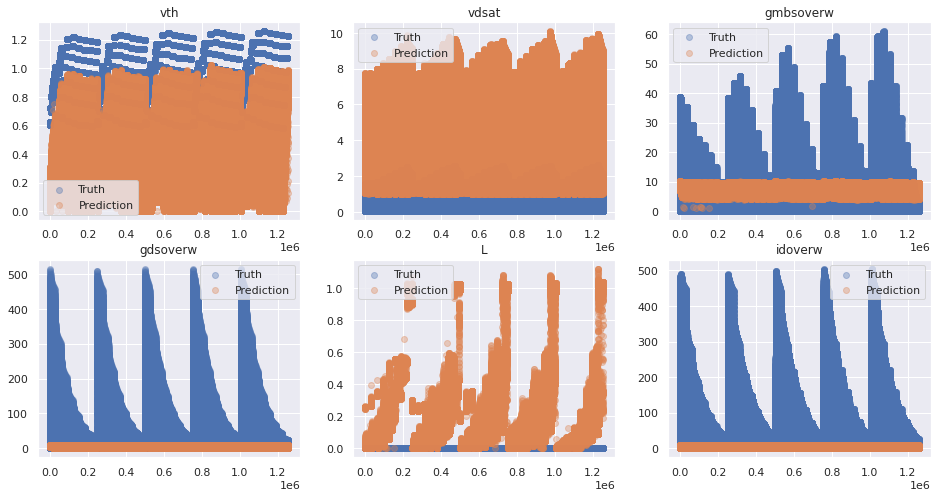

In [66]:
fig, axs = plt.subplots(figsize=(16,8), nrows=2, ncols=3)
axs      = axs.flatten()

for (n,c) in enumerate(params_y):
    axs[n].scatter(range(len(tru_y[c].values)), tru_y[c].values, alpha=0.35, label="Truth")
    axs[n].scatter(range(len(prd_y[c].values)), prd_y[c].values, alpha=0.35, label="Prediction")
    axs[n].grid("on")
    axs[n].legend()
    axs[n].set_title(c)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [ ]:
(setv trace-tru (.sort-values (get data-raw (& (= data-raw.Vds 1.65)
                                               (= data-raw.Vbs 0.0)
                                               (= data-raw.W (np.random.choice (.unique data-raw.W)))
                                               (= data-raw.L (np.random.choice (.unique data-raw.L)))))
                              :by ["gmoverid"]))

(setv device-prefix f"./models/{tech}-{device-type}-{time-stamp}/{tech}-{device-type}"
      device (PrimitiveDevice device-prefix))

(setv trace-prd (device.predict (.copy trace-tru)))

(setv (, fig (, ax1 ax2)) (plt.subplots 2 1 :sharey False))
(ax1.plot trace-tru.gmoverid trace-tru.idoverw :label f"Truth")
(ax1.plot trace-tru.gmoverid trace-prd.idoverw :label f"Prediction")
(ax1.grid)
(ax1.set-yscale "log")
(ax1.set-xlabel "gm/Id [1/V]")
(ax1.set-ylabel "Id/W [A/m]")
(ax1.legend)
(ax2.plot trace-tru.gmoverid trace-tru.gdsoverw :label f"Truth")
(ax2.plot trace-tru.gmoverid trace-prd.gdsoverw :label f"Prediction")
(ax2.grid)
(ax2.set-xlabel "gm/Id [1/V]")
(ax2.set-ylabel "gds/W [S/m]")
(ax2.legend)
(plt.show)
